# FOREX Trading Strategy based on Taylor Rule

## 1. Data Preparation

### 1.1 Merging Data

In [1]:
import pandas as pd

In [2]:
fundamentals = pd.read_csv('final_project_data.csv', parse_dates = True)
fundamentals.set_index('Date', inplace=True)
fundamentals.index = pd.to_datetime(fundamentals.index)
fundamentals

,GT02,GTGBP2YR,UKRPCJYR Index,CPI YOY Index,IP Index,UKIPI Index
Date,,,,,,
1989-03-31,9.668,NaN,NaN,NaN,NaN,NaN
1989-04-03,9.528,NaN,NaN,NaN,NaN,NaN
1989-04-04,9.405,NaN,NaN,NaN,NaN,NaN
1989-04-05,9.491,NaN,NaN,NaN,NaN,NaN
1989-04-06,9.526,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2023-12-27,4.244,3.955,NaN,NaN,NaN,NaN
2023-12-28,4.278,3.979,NaN,NaN,NaN,NaN
2023-12-29,4.251,3.955,NaN,NaN,NaN,NaN


**Data Description:**


- GT02: Annual Yields on the U.S. 2-Year Government Note
- GTGBP2YR: Annual Yields on the U.K. 2-Year Government Note


- CPI YOY Index: U.S. CPI Urban Consumers YOY [monthly release]
- UKRPCJYR Index: UK CPI EU Harmonized YOY [monthly release]


- IP Index: U.S. Industrial Production [monthly release]
- UKIPI Index: U.K. Industrial Production [monthly release]


*Already matched to release date*

In [3]:
# pull the exchange rate data from yahoo finance
# GBP=X: Exchange Rates in terms of USD/GBP

import yfinance as yf

exrate = yf.download("GBP=X", start="1989-03-31", end="2024-01-18", interval='1d')
exrate = exrate[["Open"]]
exrate.index = pd.to_datetime(exrate.index)
exrate

[*********************100%%**********************]  1 of 1 completed


,Open
Date,
2003-12-01,0.580110
2003-12-02,0.581730
2003-12-03,0.577870
2003-12-04,0.578900
2003-12-05,0.581190
...,...
2024-01-11,0.784610
2024-01-12,0.782500
2024-01-15,0.785150


In [4]:
# merge data
data0 = pd.merge_asof(fundamentals, exrate, left_index = True, right_index = True, direction = 'forward')

# merge the data with the opening price for the following day after the release,
# so we enter a trade at the next available “tick”.
data0['Open'] = data0['Open'].shift(-1)

data0

,GT02,GTGBP2YR,UKRPCJYR Index,CPI YOY Index,IP Index,UKIPI Index,Open
Date,,,,,,,
1989-03-31,9.668,NaN,NaN,NaN,NaN,NaN,0.580110
1989-04-03,9.528,NaN,NaN,NaN,NaN,NaN,0.580110
1989-04-04,9.405,NaN,NaN,NaN,NaN,NaN,0.580110
1989-04-05,9.491,NaN,NaN,NaN,NaN,NaN,0.580110
1989-04-06,9.526,NaN,NaN,NaN,NaN,NaN,0.580110
...,...,...,...,...,...,...,...
2023-12-27,4.244,3.955,NaN,NaN,NaN,NaN,0.781110
2023-12-28,4.278,3.979,NaN,NaN,NaN,NaN,0.785210
2023-12-29,4.251,3.955,NaN,NaN,NaN,NaN,0.785546


In [5]:
# change variable labels
data0.rename(columns={'GT02': 'I_US', 'GTGBP2YR': 'I_UK',
                     'UKRPCJYR Index': 'INFL_UK', 'CPI YOY Index': 'INFL_US',
                     'IP Index': 'OUTPUT_US', 'UKIPI Index': 'OUTPUT_UK',
                     'Open': 'EX_USDGBP'},
            inplace=True)
data0

,I_US,I_UK,INFL_UK,INFL_US,OUTPUT_US,OUTPUT_UK,EX_USDGBP
Date,,,,,,,
1989-03-31,9.668,NaN,NaN,NaN,NaN,NaN,0.580110
1989-04-03,9.528,NaN,NaN,NaN,NaN,NaN,0.580110
1989-04-04,9.405,NaN,NaN,NaN,NaN,NaN,0.580110
1989-04-05,9.491,NaN,NaN,NaN,NaN,NaN,0.580110
1989-04-06,9.526,NaN,NaN,NaN,NaN,NaN,0.580110
...,...,...,...,...,...,...,...
2023-12-27,4.244,3.955,NaN,NaN,NaN,NaN,0.781110
2023-12-28,4.278,3.979,NaN,NaN,NaN,NaN,0.785210
2023-12-29,4.251,3.955,NaN,NaN,NaN,NaN,0.785546


### 1.2 Handling NAs

In [6]:
data0.isnull().sum()

I_US          480
I_UK         1082
INFL_UK      8919
INFL_US      8911
OUTPUT_US    8748
OUTPUT_UK    8749
EX_USDGBP       2
dtype: int64

In [7]:
# Earliest Release Dates of Fundamentals
print(data0['I_US'].first_valid_index())
print(data0['I_UK'].first_valid_index())
print(data0['INFL_US'].first_valid_index())
print(data0['INFL_UK'].first_valid_index())
print(data0['OUTPUT_US'].first_valid_index())
print(data0['OUTPUT_UK'].first_valid_index())

1989-03-31 00:00:00
1992-01-02 00:00:00
2002-10-18 00:00:00
2003-06-17 00:00:00
1989-04-18 00:00:00
1989-04-18 00:00:00


In [8]:
# forward fill NaN values
data1 = data0.copy().ffill()
data1

,I_US,I_UK,INFL_UK,INFL_US,OUTPUT_US,OUTPUT_UK,EX_USDGBP
Date,,,,,,,
1989-03-31,9.668,NaN,NaN,NaN,NaN,NaN,0.580110
1989-04-03,9.528,NaN,NaN,NaN,NaN,NaN,0.580110
1989-04-04,9.405,NaN,NaN,NaN,NaN,NaN,0.580110
1989-04-05,9.491,NaN,NaN,NaN,NaN,NaN,0.580110
1989-04-06,9.526,NaN,NaN,NaN,NaN,NaN,0.580110
...,...,...,...,...,...,...,...
2023-12-27,4.244,3.955,3.9,3.1,102.4301,93.9,0.781110
2023-12-28,4.278,3.979,3.9,3.1,102.4301,93.9,0.785210
2023-12-29,4.251,3.955,3.9,3.1,102.4301,93.9,0.785546


In [9]:
# drop NaNs before the date of '2001-01-01'
# Not dropping the NaNs between '2001-01-01' and '2003-06-16' is because
# the output data in this time period is useful to later calculate the output_potential and output_gap
data1 = data1[data1.index >= '2001-01-01']

# drop the last 2 row because they do not contain EX_USDGBP value initially
data1 = data1.iloc[:-2]
data1

,I_US,I_UK,INFL_UK,INFL_US,OUTPUT_US,OUTPUT_UK,EX_USDGBP
Date,,,,,,,
2001-01-02,4.862,5.230,NaN,NaN,92.6618,94.2,0.580110
2001-01-03,4.929,5.221,NaN,NaN,92.6618,94.2,0.580110
2001-01-04,4.787,5.211,NaN,NaN,92.6618,94.2,0.580110
2001-01-05,4.569,5.200,NaN,NaN,92.6618,94.2,0.580110
2001-01-08,4.560,5.179,NaN,NaN,92.6618,94.2,0.580110
...,...,...,...,...,...,...,...
2023-12-22,4.324,4.030,3.9,3.1,102.4301,93.9,0.787100
2023-12-26,4.356,4.030,3.9,3.1,102.4301,93.9,0.785650
2023-12-27,4.244,3.955,3.9,3.1,102.4301,93.9,0.781110


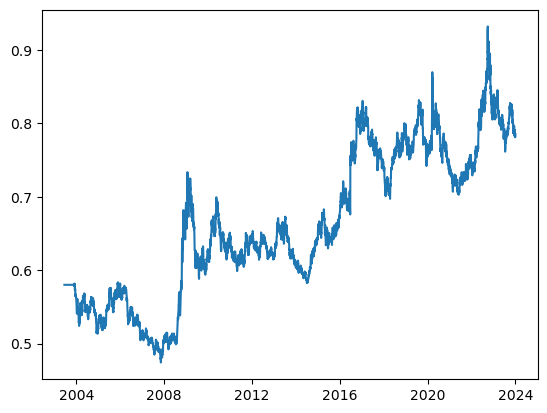

             I_US   I_UK  INFL_UK  INFL_US  OUTPUT_US  OUTPUT_UK  EX_USDGBP
Date                                                                       
2003-11-25  1.836  4.578      1.4      2.0    91.5005      103.2    0.58011
2003-11-26  1.928  4.551      1.4      2.0    91.5005      103.2    0.58011
2003-11-27  1.928  4.605      1.4      2.0    91.5005      103.2    0.58011
2003-11-28  2.048  4.586      1.4      2.0    91.5005      103.2    0.58011
2003-11-30  2.048  4.586      1.4      2.0    91.5005      103.2    0.58011
2003-12-01  2.096  4.611      1.4      2.0    91.5005      103.2    0.58173
2003-12-02  2.056  4.606      1.4      2.0    91.5005      103.2    0.57787
2003-12-03  2.072  4.563      1.4      2.0    91.5005      103.2    0.57890
2003-12-04  2.040  4.537      1.4      2.0    91.5005      103.2    0.58119
2003-12-05  1.871  4.446      1.4      2.0    91.5005      103.2    0.57820


In [10]:
# Examine the changes of EX_USDGBP
import matplotlib.pyplot as plt
plt.plot(data1['EX_USDGBP'][data1.index >= '2003-06-17'])
plt.show()

print(data1[data1.index >= '2003-11-25'][:10])

# notice that the exchange rate is started to float since 2003-12-01 (actually the opening price at 2003-12-02)
# therefore, we later will drop data with dates before 2003-12-01

### 1.3 Data Transformation

The simplest specification of the exchange rate forecasting equation is as follows:

$$s_{t+1} - s_t = \Delta s_{t+1} = \beta_1 + \beta_2 (\pi^{us}_t - \pi^{uk}_t) + \beta_3 (\text{gap}^{us}_t - \text{gap}^{uk}_t) + \epsilon_t $$


*s: exchange rate in terms of USD/GBP.*


We need to define potential output for the output gap, since we do not know which definition of potential output is used by central banks. Here we consider percentage deviations of actual output from a linear time trend as output gap.

The potential output for the first period is calculated using output series from 2001-01-02 to 2003-11-30, and it is updated each period in order to mimic as closely as possible the information available to the central banks at the time the decisions were made.

In [11]:
len(data1[(data1.index >= '2001-01-02') & (data1.index <= '2003-11-30')])

769

In [12]:
data2 = data1.copy()
data2.reset_index(inplace = True) # convert index into a column

In [13]:
## Dependent Variable : s_t+1, s_t

import numpy as np

# s_current : log of nominal exchange rates at t
s_current = np.log(data2.loc[768:len(data2)-2, 'EX_USDGBP']).reset_index(drop=True)
s_current = s_current.rename('s_current')

# s_future : log of nominal exchange rates at t+1
s_future = np.log(data2.loc[769:, 'EX_USDGBP']).reset_index(drop=True)
s_future = s_future.rename('s_future')

# s_change : change in log of exchange rates (s_t+1 - s_t)
s_change = s_future - s_current
s_change = s_change.rename('s_change')

In [14]:
## Independent Variables

# infl_us, infl_uk : us inflation at t, japan inflation at t
infl_uk = data2.loc[768:len(data2)-2, 'INFL_UK'].reset_index(drop=True) # includes row "len(data2)-2"
infl_us = data2.loc[768:len(data2)-2,'INFL_US'].reset_index(drop=True)
infl_diff = infl_us - infl_uk
infl_diff = infl_diff.rename('infl_diff')

# output_us, output_japan : us output at t, japan output at t
output_uk = data2.loc[768:len(data2)-2,'OUTPUT_UK'].reset_index(drop=True)
output_us = data2.loc[768:len(data2)-2,'OUTPUT_US'].reset_index(drop=True)

# date : Time at t+1 (s_change is already realized at the moment)
date = data2.loc[769:,'Date'].reset_index(drop=True)

# Combine all variables into a new data set
data3 = pd.concat([date, s_future, s_current, s_change, infl_diff, output_uk, output_us], axis=1)
data3

,Date,s_future,s_current,s_change,infl_diff,OUTPUT_UK,OUTPUT_US
0,2003-12-01,-0.541749,-0.544538,0.002789,0.6,103.2,91.5005
1,2003-12-02,-0.548406,-0.541749,-0.006657,0.6,103.2,91.5005
2,2003-12-03,-0.546626,-0.548406,0.001781,0.6,103.2,91.5005
3,2003-12-04,-0.542678,-0.546626,0.003948,0.6,103.2,91.5005
4,2003-12-05,-0.547835,-0.542678,-0.005158,0.6,103.2,91.5005
...,...,...,...,...,...,...,...
5305,2023-12-22,-0.239400,-0.237927,-0.001473,-0.8,93.9,102.4301
5306,2023-12-26,-0.241244,-0.239400,-0.001844,-0.8,93.9,102.4301
5307,2023-12-27,-0.247039,-0.241244,-0.005795,-0.8,93.9,102.4301
5308,2023-12-28,-0.241804,-0.247039,0.005235,-0.8,93.9,102.4301


In [15]:
#combine all variables for interest rate differential strategy
df = pd.concat([date,s_future,s_current,s_change,data2["I_US"],data2["I_UK"]],axis = 1)
df["ir_diff"] = df["I_US"] - df["I_UK"]
df = df[0:5310]
df

,Date,s_future,s_current,s_change,I_US,I_UK,ir_diff
0,2003-12-01,-0.541749,-0.544538,0.002789,4.862,5.230,-0.368
1,2003-12-02,-0.548406,-0.541749,-0.006657,4.929,5.221,-0.292
2,2003-12-03,-0.546626,-0.548406,0.001781,4.787,5.211,-0.424
3,2003-12-04,-0.542678,-0.546626,0.003948,4.569,5.200,-0.631
4,2003-12-05,-0.547835,-0.542678,-0.005158,4.560,5.179,-0.619
...,...,...,...,...,...,...,...
5305,2023-12-22,-0.239400,-0.237927,-0.001473,0.111,-0.112,0.223
5306,2023-12-26,-0.241244,-0.239400,-0.001844,0.111,-0.112,0.223
5307,2023-12-27,-0.247039,-0.241244,-0.005795,0.111,-0.112,0.223
5308,2023-12-28,-0.241804,-0.247039,0.005235,0.114,-0.097,0.211


In [16]:
## Estimate of Output Gap
# Linear Trend
# Output Gap in UK and US

import statsmodels.formula.api as smf

data2['t'] = pd.DataFrame({'t' : range(1,len(data2)+1)}) # generate a new column to record the number of days

for i in range(0,len(data3)): # Updating the potential output each period
    
    # note that we are expanding the traning set each loop, starting from 0:769(does not include row 769)
    linear_trend_uk = smf.ols(formula = 'OUTPUT_UK ~ t', data = data2[0:769+i]).fit()
    
    # we make a prediction for the next period (starting from row 769, which refers to '2003-12-01')
    data3.loc[i,'uk_potential'] = linear_trend_uk.predict(data2['t'][769+i:770+i])[769+i]
    
    # Repeat for the US
    linear_trend_us = smf.ols(formula = 'OUTPUT_US ~ t', data = data2[0:769+i]).fit()
    data3.loc[i,'us_potential'] = linear_trend_us.predict(data2['t'][769+i:770+i])[769+i]

# Consider percentage deviations of actual output from a linear time trend as output gap
data3['uk_gap'] = (data3['OUTPUT_UK'] - data3['uk_potential'])/data3['uk_potential']
data3['us_gap'] = (data3['OUTPUT_US'] - data3['us_potential'])/data3['us_potential']

# Output Gap differential between US and UK
data3['gap_diff'] = data3['us_gap'] - data3['uk_gap']

# Keep variables only used for our model
data3 = data3[['Date', 's_future', 's_current', 's_change', 'infl_diff', 'gap_diff']]

In [17]:
## Make sure all columns have float numbers
data3.loc[:,'s_future'] = data3.loc[:,'s_future'].apply(float)
data3.loc[:,'s_current'] = data3.loc[:,'s_current'].apply(float)
data3.loc[:,'s_change'] = data3.loc[:,'s_change'].apply(float)
data3.loc[:,'infl_diff'] = data3.loc[:,'infl_diff'].apply(float)
data3.loc[:,'gap_diff'] = data3.loc[:,'gap_diff'].apply(float)

/var/folders/zp/b5rvy4wn3gd_tffbrx2__df40000gn/T/ipykernel_56331/3346383366.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3.loc[:,'s_future'] = data3.loc[:,'s_future'].apply(float)
/var/folders/zp/b5rvy4wn3gd_tffbrx2__df40000gn/T/ipykernel_56331/3346383366.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3.loc[:,'s_current'] = data3.loc[:,'s_current'].apply(float)
/var/folders/zp/b5rvy4wn3gd_tffbrx2__df40000gn/T/ipykernel_56331/3346383366.py:4: SettingWithCopyWarning: 
A value is trying to 

In [18]:
data3

,Date,s_future,s_current,s_change,infl_diff,gap_diff
0,2003-12-01,-0.541749,-0.544538,0.002789,0.6,-0.002433
1,2003-12-02,-0.548406,-0.541749,-0.006657,0.6,-0.002346
2,2003-12-03,-0.546626,-0.548406,0.001781,0.6,-0.002259
3,2003-12-04,-0.542678,-0.546626,0.003948,0.6,-0.002173
4,2003-12-05,-0.547835,-0.542678,-0.005158,0.6,-0.002087
...,...,...,...,...,...,...
5305,2023-12-22,-0.239400,-0.237927,-0.001473,-0.8,0.004094
5306,2023-12-26,-0.241244,-0.239400,-0.001844,-0.8,0.004067
5307,2023-12-27,-0.247039,-0.241244,-0.005795,-0.8,0.004040
5308,2023-12-28,-0.241804,-0.247039,0.005235,-0.8,0.004013


- Date: t+1
- infl_diff: t
- gap_diff: t
- s_change = s_t+1 - s_t = log(EX_t+1) - log(EX_t) = log(EX_t+1/EX_t) = cc return of exchange rate
- s_change_fitted = s_t+1_forecast - s_t

### 1.4 Run regressions to generate the forecasts of exchange rates based on the Taylor rule

In [50]:
# Create empty columns for fitted values of the changes of log exchange rates
data4 = data3.copy()

data4['s_change_fitted'] = np.nan

# Out-of-sample Forecasts with rolling window of 750 days
w = 1200
for i in range(w,len(data4)):
    
    # we regress the change in the exchange rate on the taylor rule fundamentals
    tmp = smf.ols(formula = 's_change ~ infl_diff + gap_diff', data = data4[i-w:i]).fit()
    
    # make a prediction for the next period
    data4.loc[i,'s_change_fitted'] = tmp.predict(data3[['infl_diff', 'gap_diff']][i:i+1])[i]

# Forecasts
data4['s_forecast'] = data4['s_change_fitted'] + data4['s_current']

# Forecast Error
# data4['error'] = data4['s_future'] - data4['s_forecast']

data4

,Date,s_future,s_current,s_change,infl_diff,gap_diff,s_change_fitted,s_forecast
0,2003-12-01,-0.541749,-0.544538,0.002789,0.6,-0.002433,NaN,NaN
1,2003-12-02,-0.548406,-0.541749,-0.006657,0.6,-0.002346,NaN,NaN
2,2003-12-03,-0.546626,-0.548406,0.001781,0.6,-0.002259,NaN,NaN
3,2003-12-04,-0.542678,-0.546626,0.003948,0.6,-0.002173,NaN,NaN
4,2003-12-05,-0.547835,-0.542678,-0.005158,0.6,-0.002087,NaN,NaN
...,...,...,...,...,...,...,...,...
5305,2023-12-22,-0.239400,-0.237927,-0.001473,-0.8,0.004094,0.000191,-0.237736
5306,2023-12-26,-0.241244,-0.239400,-0.001844,-0.8,0.004067,0.000182,-0.239218
5307,2023-12-27,-0.247039,-0.241244,-0.005795,-0.8,0.004040,0.000175,-0.241069
5308,2023-12-28,-0.241804,-0.247039,0.005235,-0.8,0.004013,0.000167,-0.246872


## 2. Trading Strategy

In [51]:
data5 = data4.dropna()
data5 = data5.copy()

data5["error"]=data5["s_change"]-data5["s_change_fitted"]

# Strategy 1: bad performance
# go long if we forecast the exchange rate will increase
# go short if we forecast the exchange rate will decrease
#data5['signal'] = np.where(data5['s_change_fitted'] >= 0, 1, -1)

# Strategy 2: inaction strategy & state contingent
z = 0.6
k = 0.8
data5["std"] = data5["error"].ewm(alpha = k, adjust = False).std(bias=False)
data5["signal"] = np.where(data5["error"].abs()>z*data5["std"], 1, np.NaN) * np.sign(data5["error"])
data5["signal"] = data5["signal"].ffill()

# calculate returns
# s_change is the cc return of exchange rate
# strategy_return is the simple return of exchange rate
data5['strategy_return'] = (np.exp((data5['signal'].shift() * data5['s_change']).cumsum())-1)*100

data5 = data5.dropna()
data5

,Date,s_future,s_current,s_change,infl_diff,gap_diff,s_change_fitted,s_forecast,error,std,signal,strategy_return
1203,2008-06-20,-0.680093,-0.679343,-0.000750,0.9,0.010886,-0.000220,-0.679563,-0.000530,0.004099,-1.0,0.075022
1204,2008-06-23,-0.675779,-0.680093,0.004314,0.9,0.010825,-0.000228,-0.680320,0.004542,0.004569,1.0,-0.355758
1205,2008-06-24,-0.678180,-0.675779,-0.002401,0.9,0.010765,-0.000215,-0.675994,-0.002186,0.004335,1.0,-0.594701
1206,2008-06-25,-0.680389,-0.678180,-0.002209,0.9,0.010705,-0.000215,-0.678395,-0.001994,0.002039,-1.0,-0.814056
1207,2008-06-26,-0.686827,-0.680389,-0.006438,0.9,0.010646,-0.000208,-0.680597,-0.006231,0.003194,-1.0,-0.173408
...,...,...,...,...,...,...,...,...,...,...,...,...
5305,2023-12-22,-0.239400,-0.237927,-0.001473,-0.8,0.004094,0.000191,-0.237736,-0.001664,0.003140,1.0,92.176372
5306,2023-12-26,-0.241244,-0.239400,-0.001844,-0.8,0.004067,0.000182,-0.239218,-0.002026,0.001417,-1.0,91.822343
5307,2023-12-27,-0.247039,-0.241244,-0.005795,-0.8,0.004040,0.000175,-0.241069,-0.005970,0.002842,-1.0,92.937268
5308,2023-12-28,-0.241804,-0.247039,0.005235,-0.8,0.004013,0.000167,-0.246872,0.005068,0.007207,1.0,91.929833


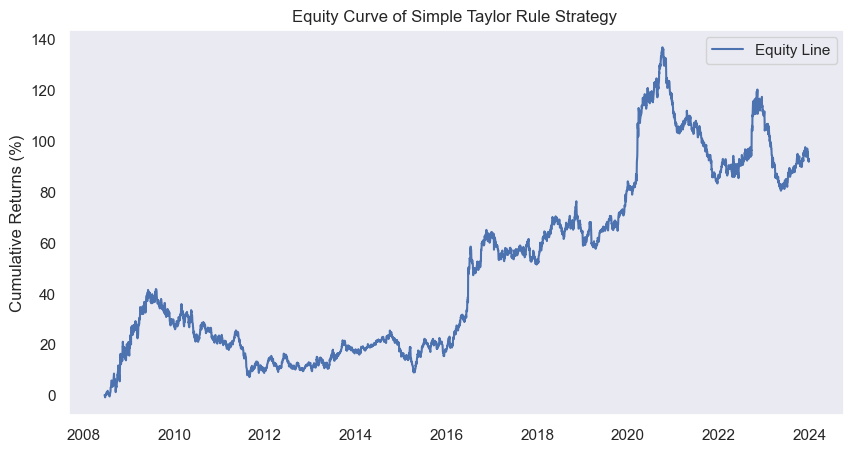

In [52]:
data6 = data5.copy()
data6.index = pd.to_datetime(data5.Date)
plt.figure(figsize = (10, 5))
plt.plot(data6['strategy_return'])
plt.ylabel("Cumulative Returns (%)")
plt.title("Equity Curve of Simple Taylor Rule Strategy ")
plt.legend(["Equity Line"])
plt.grid()

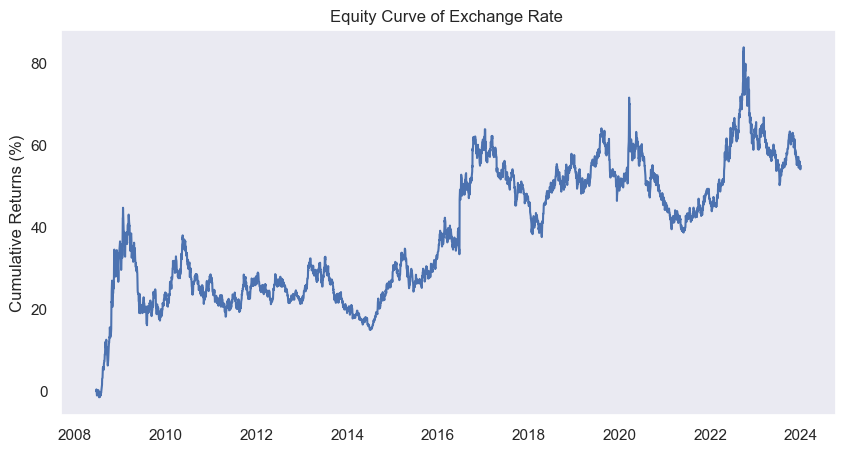

In [53]:
plt.figure(figsize = (10, 5))
a = (np.exp(data6['s_change'].cumsum())-1)*100
plt.ylabel("Cumulative Returns (%)")
plt.title("Equity Curve of Exchange Rate ")
plt.plot(a)
plt.grid()

## 3. Hyperparameter Optimization

In [54]:
# alpha(k): weight to current error in calculating the ewm standard deviation of s_change_fitted
# z: critical value in inaction strategy
# w: rolling window size of regressing s_change on taylor rule components

In [55]:
data5['Date'] = pd.to_datetime(data5['Date'])
data5 = data5.set_index('Date')
data5

,s_future,s_current,s_change,infl_diff,gap_diff,s_change_fitted,s_forecast,error,std,signal,strategy_return
Date,,,,,,,,,,,
2008-06-20,-0.680093,-0.679343,-0.000750,0.9,0.010886,-0.000220,-0.679563,-0.000530,0.004099,-1.0,0.075022
2008-06-23,-0.675779,-0.680093,0.004314,0.9,0.010825,-0.000228,-0.680320,0.004542,0.004569,1.0,-0.355758
2008-06-24,-0.678180,-0.675779,-0.002401,0.9,0.010765,-0.000215,-0.675994,-0.002186,0.004335,1.0,-0.594701
2008-06-25,-0.680389,-0.678180,-0.002209,0.9,0.010705,-0.000215,-0.678395,-0.001994,0.002039,-1.0,-0.814056
2008-06-26,-0.686827,-0.680389,-0.006438,0.9,0.010646,-0.000208,-0.680597,-0.006231,0.003194,-1.0,-0.173408
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,-0.239400,-0.237927,-0.001473,-0.8,0.004094,0.000191,-0.237736,-0.001664,0.003140,1.0,92.176372
2023-12-26,-0.241244,-0.239400,-0.001844,-0.8,0.004067,0.000182,-0.239218,-0.002026,0.001417,-1.0,91.822343
2023-12-27,-0.247039,-0.241244,-0.005795,-0.8,0.004040,0.000175,-0.241069,-0.005970,0.002842,-1.0,92.937268


In [56]:
### Risk Free Rate

# Load the dataset
rf = pd.read_csv('DGS1.csv', parse_dates=['DATE'])

# Replace '.' with NaN to facilitate forward filling of values
rf['DGS1'].replace('.', None, inplace=True)

# Convert 'DGS1' to numeric, coercing errors will turn the problematic entries into NaN
rf['DGS1'] = pd.to_numeric(rf['DGS1'], errors='coerce')

# Forward fill the NaN values with the last available value
rf['DGS1'] = rf['DGS1'].fillna(method='ffill')

# Set 'DATE' as the index
rf.set_index('DATE', inplace=True)

# Resample the data
year_rf = rf.resample('Y').mean()

year_rf = year_rf.mean() / 100

year_rf

DGS1    0.015347
dtype: float64

In [64]:
def forecast(w):
    # Create empty columns for fitted values of the changes of log exchange rates
    df = data3.copy()

    df['s_change_fitted'] = np.nan

    # Out-of-sample Forecasts with rolling window of w days
    for i in range(w,len(data4)):

        # we regress the change in the exchange rate on the taylor rule fundamentals
        tmp = smf.ols(formula = 's_change ~ infl_diff + gap_diff', data = df[i-w:i]).fit()

        # make a prediction for the next period
        df.loc[i,'s_change_fitted'] = tmp.predict(data3[['infl_diff', 'gap_diff']][i:i+1])[i]

    # Forecasts
    df['s_forecast'] = df['s_change_fitted'] + df['s_current']

    # Forecast Error
    # data4['error'] = data4['s_future'] - data4['s_forecast']

    return df

In [73]:
def calculate_metrics(w,k,z):

    df = forecast(w).copy().dropna()
    
    df.index = pd.to_datetime(df['Date'])
    
    #strategy return
    df["error"]=df["s_change"]-df["s_change_fitted"]
    df["std"] = df["error"].ewm(alpha = k, adjust = False).std(bias=False)
    df["signal"] = np.where(df["error"].abs()>z*df["std"], 1, np.NaN) * np.sign(df["error"])
    df["signal"] = df["signal"].ffill()
    df["simple_return"] = np.exp((df['signal'].shift() * df['s_change']).cumsum())-1
    df['strategy_return'] = df["simple_return"]*100
    data6 = df.dropna().copy()
    
    #calculate CCROR
    data6['simple_return'] = (data6['simple_return'] +1)*100000

    log_change = np.log(data6['simple_return'].iloc[-1]/
                        data6['simple_return'].iloc[1])
    n_years = (len(data6)/252)
    ccror = log_change/n_years*100

    #calculate AR
    ar = ((data6['simple_return'].iloc[-1]/
          data6['simple_return'].iloc[1])**(1/n_years)-1)*100
    
    #calculate Sharpe Ratio
    rf = 0.015
    excess = np.exp((data6['signal'].shift() * data6['s_change']).resample('Y').sum())- 1 - rf
    sr = excess.mean()/excess.std()
    
    print ('complete', w)
    
    return round(ccror, 3), round(ar, 3), round(sr, 3)

In [ ]:
w_values = np.arange(750, 1300, 50)
k_values = np.arange(0.1, 1, 0.1)
z_values = np.arange(0, 2.5, 0.2)

results = [] 
for w in w_values:
    for k in k_values:
        for z in z_values:
            CCROR,AR,Sharpe = calculate_metrics(w,k,z)
            results.append({'w':w,'k': k, 'z': z, 'CCROR': CCROR, 'AR':AR, 'Sharpe': Sharpe})
            
# Convert results to a DataFrame for easier handling
results_df = pd.DataFrame(results)
sorted_results = results_df.sort_values(by='Sharpe', ascending=False)
sorted_results = sorted_results.dropna()

In [76]:
sorted_results

,w,k,z,CCROR,AR,Sharpe
930,1100,0.9,1.4,4.175,4.264,0.391
1161,1200,0.9,0.8,4.417,4.516,0.355
1047,1150,0.9,1.4,4.226,4.317,0.355
1164,1200,0.9,1.4,4.313,4.407,0.347
331,850,0.8,1.2,3.365,3.422,0.317
...,...,...,...,...,...,...
997,1150,0.5,1.8,-5.345,-5.205,-0.923
295,850,0.5,1.8,-4.045,-3.965,-0.931
529,950,0.5,1.8,-3.803,-3.731,-0.980
1231,1250,0.5,1.8,-5.599,-5.445,-1.002


In [140]:
sorted_results_2 = results_df.sort_values(by='AR', ascending=False)
sorted_results_2 = sorted_results.dropna()

In [141]:
sorted_results_2

,w,k,z,CCROR,AR,Sharpe
1161,1200,0.9,0.8,4.417,4.516,0.355
1164,1200,0.9,1.4,4.313,4.407,0.347
1047,1150,0.9,1.4,4.226,4.317,0.355
930,1100,0.9,1.4,4.175,4.264,0.391
1163,1200,0.9,1.2,4.119,4.205,0.303
...,...,...,...,...,...,...
412,900,0.5,1.8,-4.122,-4.038,-1.019
178,800,0.5,1.8,-4.522,-4.422,-0.862
1114,1200,0.5,1.8,-4.730,-4.620,-0.797
997,1150,0.5,1.8,-5.345,-5.205,-0.923


In [39]:
import seaborn as sns

In [149]:
def heatmap(x, y, metric, values):
    
    # specify the columns I will be pulling from the results
    p2p = values[[x, y, metric]]
    
    # If p > 2, we need to group 
    heat = np.round(p2p.groupby([x,y]).mean(),1)
    heat = heat.unstack()[metric]

    # round labels
    heat.index = np.round(heat.index,2)
    heat.columns = np.round(heat.columns,2)

    # make plot
    f, ax = plt.subplots(figsize=(11.5, 5))
    ax = sns.heatmap(heat, fmt='.1g')
    ax.set_title("heatmap of " + x + " and " + y,size = 18)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlabel(y, size = 18)
    ax.set_ylabel(x, size = 18)
    ax.collections[0].colorbar.set_label(metric, size = 18)
    sns.set(font_scale=1)
    plt.show()

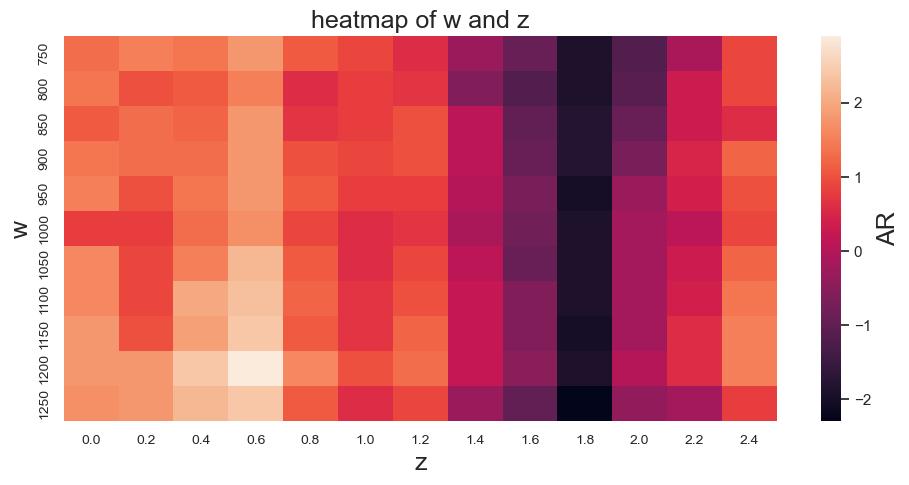

In [152]:
heatmap("w", "z", "AR", sorted_results)

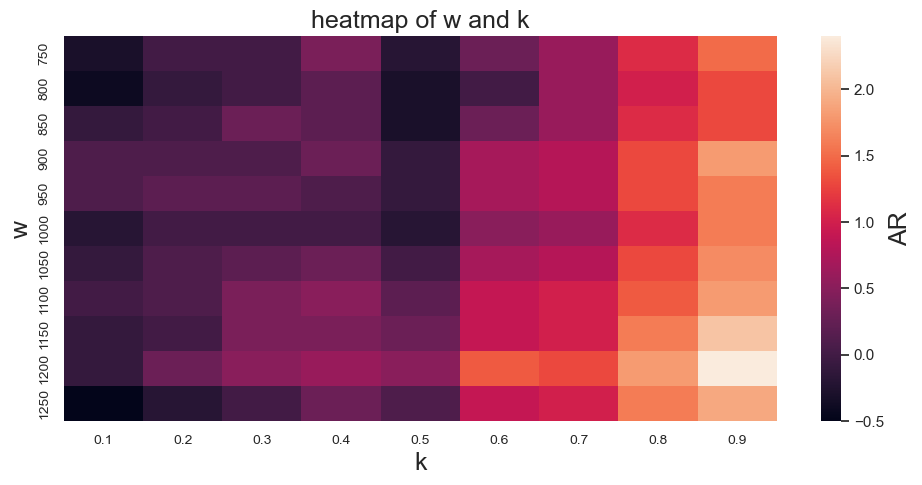

In [153]:
heatmap("w", "k","AR", sorted_results)

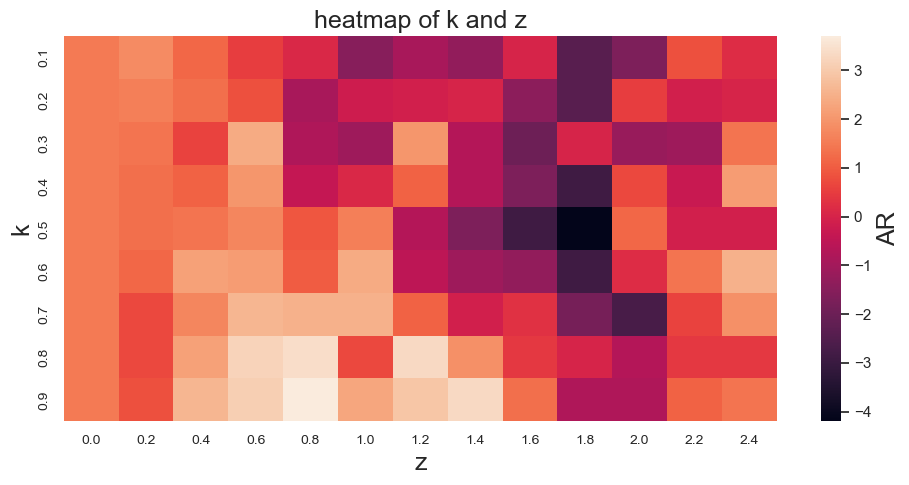

In [154]:
heatmap("k", "z", "AR", sorted_results)

## 4. Performance Evaluation

### 4.1 Equity Curve

In [250]:
data3

,Date,s_future,s_current,s_change,infl_diff,gap_diff
0,2003-12-01,-0.541749,-0.544538,0.002789,0.6,-0.002433
1,2003-12-02,-0.548406,-0.541749,-0.006657,0.6,-0.002346
2,2003-12-03,-0.546626,-0.548406,0.001781,0.6,-0.002259
3,2003-12-04,-0.542678,-0.546626,0.003948,0.6,-0.002173
4,2003-12-05,-0.547835,-0.542678,-0.005158,0.6,-0.002087
...,...,...,...,...,...,...
5305,2023-12-22,-0.239400,-0.237927,-0.001473,-0.8,0.004094
5306,2023-12-26,-0.241244,-0.239400,-0.001844,-0.8,0.004067
5307,2023-12-27,-0.247039,-0.241244,-0.005795,-0.8,0.004040
5308,2023-12-28,-0.241804,-0.247039,0.005235,-0.8,0.004013


In [252]:
# Create empty columns for fitted values of the changes of log exchange rates
data6 = data3.copy()
#data6.index = pd.to_datetime(data6.index)

data6['s_change_fitted'] = np.nan

# Out-of-sample Forecasts with rolling window of 1200 days
w = 1200
for i in range(w,len(data4)):
    
    # we regress the change in the exchange rate on the taylor rule fundamentals
    tmp = smf.ols(formula = 's_change ~ infl_diff + gap_diff', data = data6[i-w:i]).fit()
    
    # make a prediction for the next period
    data6.loc[i,'s_change_fitted'] = tmp.predict(data6[['infl_diff', 'gap_diff']][i:i+1])[i]

# Forecasts
data6['s_forecast'] = data6['s_change_fitted'] + data6['s_current']

# Forecast Error
data6['error'] = data6['s_future'] - data6['s_forecast']

In [254]:
k = 0.9
z = 0.8
#data6 = data6.dropna().copy()
data6["std"] = data6["error"].ewm(alpha = k, adjust = False).std(bias=False)
data6["signal"] = np.where(data6["error"].abs()>z*data6["std"], 1, np.NaN) * np.sign(data6["error"])
data6["signal"] = data6["signal"].ffill()
data6['strategy_return'] = (np.exp((data6['signal'].shift() * data6['s_change']).cumsum())-1)*100

In [255]:
data6 = data6.dropna()

In [256]:
data6

,Date,s_future,s_current,s_change,infl_diff,gap_diff,s_change_fitted,s_forecast,error,std,signal,strategy_return
1203,2008-06-20,-0.680093,-0.679343,-0.000750,0.9,0.010886,-0.000220,-0.679563,-0.000530,0.004258,-1.0,0.075022
1204,2008-06-23,-0.675779,-0.680093,0.004314,0.9,0.010825,-0.000228,-0.680320,0.004542,0.004186,1.0,-0.355758
1205,2008-06-24,-0.678180,-0.675779,-0.002401,0.9,0.010765,-0.000215,-0.675994,-0.002186,0.004534,1.0,-0.594701
1206,2008-06-25,-0.680389,-0.678180,-0.002209,0.9,0.010705,-0.000215,-0.678395,-0.001994,0.001465,-1.0,-0.814056
1207,2008-06-26,-0.686827,-0.680389,-0.006438,0.9,0.010646,-0.000208,-0.680597,-0.006231,0.003046,-1.0,-0.173408
...,...,...,...,...,...,...,...,...,...,...,...,...
5305,2023-12-22,-0.239400,-0.237927,-0.001473,-0.8,0.004094,0.000191,-0.237736,-0.001664,0.002447,-1.0,104.270559
5306,2023-12-26,-0.241244,-0.239400,-0.001844,-0.8,0.004067,0.000182,-0.239218,-0.002026,0.000793,-1.0,104.647563
5307,2023-12-27,-0.247039,-0.241244,-0.005795,-0.8,0.004040,0.000175,-0.241069,-0.005970,0.002804,-1.0,105.837030
5308,2023-12-28,-0.241804,-0.247039,0.005235,-0.8,0.004013,0.000167,-0.246872,0.005068,0.007540,-1.0,104.762239


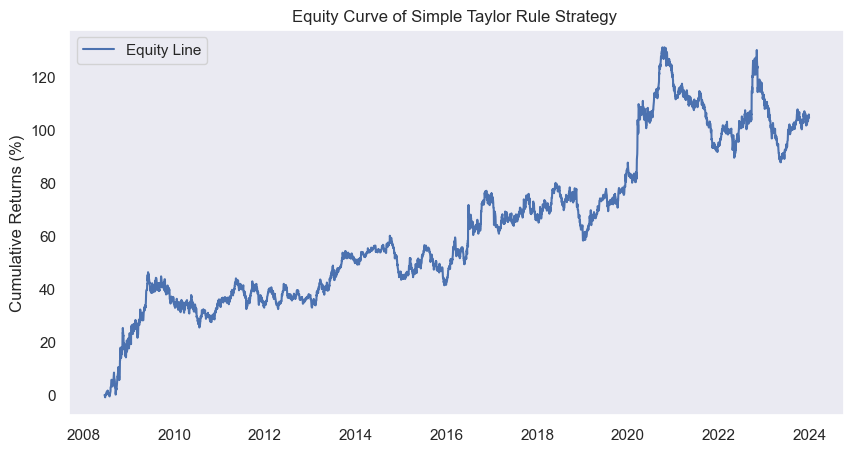

In [257]:
data6.index = pd.to_datetime(data6.Date)
plt.figure(figsize = (10, 5))
plt.plot(data6['strategy_return'])
plt.ylabel("Cumulative Returns (%)")
plt.title("Equity Curve of Simple Taylor Rule Strategy ")
plt.legend(["Equity Line"])
plt.grid()

### 4.2 Statistical Test

In [75]:
import scipy.stats as st

#### Binomial Test

In [258]:
test_frame = data6.dropna().copy()
test_frame['D'] = test_frame["signal"]

In [259]:
test_frame

,Date,s_future,s_current,s_change,infl_diff,gap_diff,s_change_fitted,s_forecast,error,std,signal,strategy_return,D
Date,,,,,,,,,,,,,
2008-06-20,2008-06-20,-0.680093,-0.679343,-0.000750,0.9,0.010886,-0.000220,-0.679563,-0.000530,0.004258,-1.0,0.075022,-1.0
2008-06-23,2008-06-23,-0.675779,-0.680093,0.004314,0.9,0.010825,-0.000228,-0.680320,0.004542,0.004186,1.0,-0.355758,1.0
2008-06-24,2008-06-24,-0.678180,-0.675779,-0.002401,0.9,0.010765,-0.000215,-0.675994,-0.002186,0.004534,1.0,-0.594701,1.0
2008-06-25,2008-06-25,-0.680389,-0.678180,-0.002209,0.9,0.010705,-0.000215,-0.678395,-0.001994,0.001465,-1.0,-0.814056,-1.0
2008-06-26,2008-06-26,-0.686827,-0.680389,-0.006438,0.9,0.010646,-0.000208,-0.680597,-0.006231,0.003046,-1.0,-0.173408,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,2023-12-22,-0.239400,-0.237927,-0.001473,-0.8,0.004094,0.000191,-0.237736,-0.001664,0.002447,-1.0,104.270559,-1.0
2023-12-26,2023-12-26,-0.241244,-0.239400,-0.001844,-0.8,0.004067,0.000182,-0.239218,-0.002026,0.000793,-1.0,104.647563,-1.0
2023-12-27,2023-12-27,-0.247039,-0.241244,-0.005795,-0.8,0.004040,0.000175,-0.241069,-0.005970,0.002804,-1.0,105.837030,-1.0


In [260]:
#test_frame['s_current'] = test_frame["Open"]
test_frame['s_future'] = test_frame["s_current"].shift(-1)

# Get the realized exchange rate
test_frame['R'] = np.where(test_frame['s_future'] >= test_frame['s_current'], 1, -1)

In [261]:
## Sample Covariance
test_frame['W'] = (test_frame['D']-np.mean(test_frame['D']))*(test_frame['R']-np.mean(test_frame['R']))
T_B = np.mean(test_frame['W'])

In [262]:
T_B

0.46234851517855485

In [263]:
## Newey-West LRV estimator
dy = test_frame['W'] - np.mean(test_frame['W'])
gamma_0 = sum((dy)**2)/len(test_frame)
gamma_1 = np.mean((dy*dy.shift(-1))[:len(test_frame)-1])
LRV = gamma_0 + 2*(1-1/2)*gamma_1

In [264]:
## Test-statistic
from scipy.stats import norm

statistic = T_B/np.sqrt(LRV/test_frame.shape[0])
print('Test statistic : ', statistic, ', 5 % critical value : ', round(norm.ppf(0.95),2))

Test statistic :  37.23505715374453 , 5 % critical value :  1.64


In [265]:
# Weighted Mean
test_frame['W_2'] = test_frame['D']*(test_frame['s_future']-test_frame['s_current'])
T_WB = np.mean(test_frame['W_2'])

In [266]:
## Newey-West LRV estimator
dy_2 = test_frame['W_2'] - np.mean(test_frame['W_2'])
gamma_0 = ((dy_2)**2).sum()/len(test_frame)
gamma_1 = np.mean((dy_2*dy_2.shift(-1))[:len(test_frame)-1])
LRV_2 = gamma_0 + 2*(1-1/2)*gamma_1

In [267]:
## Test-statistic
statistic_2 = T_WB/np.sqrt(LRV_2/len(test_frame))
print('Test statistic : ', statistic_2, ', 5 % critical value : ', round(norm.ppf(0.95),2))

Test statistic :  38.49282422124082 , 5 % critical value :  1.64


### 4.3 HFRI Metrics

In [307]:
data7 = data6.dropna().copy()

data7.index = pd.to_datetime(data7.index)
data7.set_index('Date', inplace=True)  # Set the 'Date' column as the index

# convert to monthly returns
data7['Returns'] = data7['signal'].shift() * data7['s_change'] # daily log return
returns_m = pd.DataFrame(np.exp(data7['Returns'].resample('M').sum()) - 1)

returns_m

,Returns
Date,
2008-06-30,0.001139
2008-07-31,-0.006621
2008-08-31,0.060639
2008-09-30,0.003516
2008-10-31,0.076740
...,...
2023-08-31,0.017530
2023-09-30,0.020128
2023-10-31,-0.029123


#### Risk/Return

In [289]:
### Geometric Average Monthly

GM = (np.prod(1 + returns_m))**(1/len(returns_m)) - 1
print((GM*100)[0].round(4), '%')

0.3834 %


In [290]:
### Std. Deviation

std = returns_m.std()
print(std[0].round(4))

0.0288


In [291]:
### Max Drawdown

# calculate cumulative return
dd_frame = (returns_m+1).cumprod()*100
dd_frame.columns = ['creturn']

# maximum value of returns reached by a given date
dd_frame['cmax'] = dd_frame.cummax()

# max drawdown i sometimes reported as a negative value, but it means the same thing
dd_frame['drawdowns'] = (dd_frame['cmax']-dd_frame['creturn'])/dd_frame['cmax']

# this is the max drawdown
max_drawdown = dd_frame['drawdowns'].max()

# Find the date (index) of the max drawdown
max_drawdown_date = dd_frame['drawdowns'].idxmax()

print(f"Maximum Drawdown: {max_drawdown}")
print(f"Date of Maximum Drawdown: {max_drawdown_date}")

Maximum Drawdown: 0.17683270684012264
Date of Maximum Drawdown: 2023-05-31 00:00:00


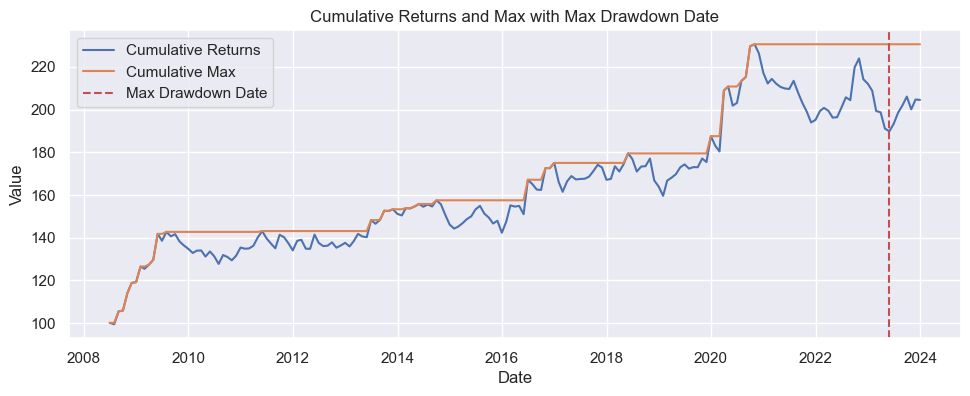

In [292]:
filtered_dd_frame = dd_frame[dd_frame.index.year < 2025]
max_drawdown_date_filtered = filtered_dd_frame['drawdowns'].idxmax()
# Plot cumulative returns and cumulative max 
plt.figure(figsize=(11.5, 4))
plt.plot(filtered_dd_frame['creturn'], label='Cumulative Returns')
plt.plot(filtered_dd_frame['cmax'], label='Cumulative Max')

# Mark the max drawdown date with a vertical line
plt.axvline(x=max_drawdown_date_filtered, color='r', linestyle='--', label='Max Drawdown Date')

plt.legend()
plt.title('Cumulative Returns and Max with Max Drawdown Date')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

In [293]:
### High Month
returns_m.columns = ['returns']

# get high month and value 
imax = returns_m['returns'].idxmax()
returns_m.loc[imax,:]

returns    0.158449
Name: 2020-03-31 00:00:00, dtype: float64

In [294]:
### Low Month

# get low month and value 
imin = returns_m['returns'].idxmin()
returns_m.loc[imin,:]

returns   -0.05802
Name: 2018-11-30 00:00:00, dtype: float64

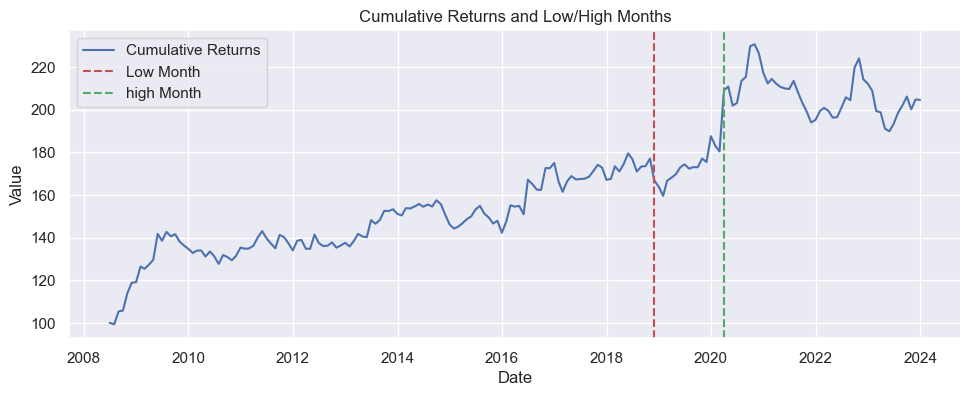

In [295]:
filtered_dd_frame = dd_frame[dd_frame.index.year < 2025]
max_drawdown_date_filtered = filtered_dd_frame['drawdowns'].idxmax()
# Plot cumulative returns and cumulative max
plt.figure(figsize=(11.5, 4))
plt.plot(filtered_dd_frame['creturn'], label='Cumulative Returns')

# Mark the max drawdown date with a vertical line
plt.axvline(x=returns_m.loc[imin,:].name, color='r', linestyle='--', label='Low Month')

plt.axvline(x=returns_m.loc[imax,:].name, color='g', linestyle='--', label='high Month')

plt.legend()
plt.title('Cumulative Returns and Low/High Months')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

In [296]:
### Annualized Return

P = 1000000
t = len(returns_m)/12
A = (np.prod(1 + returns_m))*P
AR = (((A/P)**(1/t))-1)*100

print(AR[0].round(4), '%')

4.6985 %


In [297]:
### Annualized STD

STD = returns_m.std() * np.sqrt(12)

print(STD[0].round(4))

0.0997


In [298]:
### Risk Free Rate

# Load the dataset
rf = pd.read_csv('DGS1.csv', parse_dates=['DATE'])

# Replace '.' with NaN to facilitate forward filling of values
rf['DGS1'].replace('.', None, inplace=True)

# Convert 'DGS1' to numeric, coercing errors will turn the problematic entries into NaN
rf['DGS1'] = pd.to_numeric(rf['DGS1'], errors='coerce')

# Forward fill the NaN values with the last available value
rf['DGS1'] = rf['DGS1'].fillna(method='ffill')

# Set 'DATE' as the index
rf.set_index('DATE', inplace=True)

# Resample the data 
monthly_rf = rf.resample('M').mean()

monthly_rf = monthly_rf / 100

monthly_rf = monthly_rf[21:]

#monthly_rf = monthly_rf.to_frame(name='DGS1')

print(monthly_rf)

                DGS1
DATE                
2008-06-30  0.024195
2008-07-31  0.022826
2008-08-31  0.021771
2008-09-30  0.019245
2008-10-31  0.014057
...              ...
2023-08-31  0.053674
2023-09-30  0.054324
2023-10-31  0.054250
2023-11-30  0.052805
2023-12-31  0.049524

[187 rows x 1 columns]


In [328]:
### Sharpe Ratio

df = pd.merge_asof(returns, monthly_rf, left_index = True, right_index = True, direction = 'forward')

ereturns = df['Returns'] - df['DGS1'] 

sd = ereturns.std(ddof= 1)

sharpe = ereturns.mean() *12 / (sd*np.sqrt(12))  

print(sharpe)

0.8731949190545591


In [329]:
### Percent of Winning Months

# Calculate the number of months with positive returns
nwin = (returns_m >0).sum().iloc[0]

# calculate the precentage of total
win_percent = nwin/returns_m.shape[0]*100

print(win_percent.round(4), '%')

52.4064 %


In [330]:
### VaR 5%

# you can get the emprical VAR with the pandas method
VaR = returns_m.quantile(.05)

print(VaR[0])

-3.2621951776486124


#### Regression

In [319]:
import statsmodels.formula.api as smf

In [320]:
### Correlation
# match up our returns for the series and the SP500 
returns_m['SP500'] = (yf.download('^GSPC')[['Adj Close']].pct_change()+1).resample('M').prod()-1

# get corr
returns_m.corr()

[*********************100%%**********************]  1 of 1 completed


,Returns,SP500
Returns,1.000000,-0.228357
SP500,-0.228357,1.000000


In [321]:
# make sure your returns df is in percentage units
returns_m = returns_m*100

# get the excess return for both the benchmark and your returns
returns_m['excess_return'] = ereturns
returns_m['excess_SP500'] = returns_m['SP500'] - rf

In [322]:
### Beta, Alpha and R-Squared
smf.ols('excess_return~excess_SP500', data =returns_m).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          excess_return   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     6.080
Date:                Sat, 23 Mar 2024   Prob (F-statistic):             0.0146
Time:                        13:18:02   Log-Likelihood:                 379.67
No. Observations:                 187   AIC:                            -755.3
Df Residuals:                     185   BIC:                            -748.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0136      0.002      5.745      0.000       0.009       0.018
excess_SP500    -0.0012      0.000     -2.466      0.015      -0.002      -0.000
==============================================================================
Omnibus:                       27.350   Durbin-Watson:                   1.613
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               74.519
Skew:                           0.578   Prob(JB):                     6.58e-17
Kurtosis:                       5.869   Cond. No.                         4.81
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [323]:
### Up Beta, Up Alpha and Up R-Squared
updf = returns_m[returns_m.excess_SP500 > 0]
smf.ols('excess_return~excess_SP500', data =updf).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          excess_return   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                   0.07433
Date:                Sat, 23 Mar 2024   Prob (F-statistic):              0.786
Time:                        13:18:02   Log-Likelihood:                 257.77
No. Observations:                 120   AIC:                            -511.5
Df Residuals:                     118   BIC:                            -506.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0113      0.004      2.624      0.010       0.003       0.020
excess_SP500    -0.0003      0.001     -0.273      0.786      -0.002       0.002
==============================================================================
Omnibus:                       14.662   Durbin-Watson:                   1.524
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               40.272
Skew:                           0.316   Prob(JB):                     1.80e-09
Kurtosis:                       5.767   Cond. No.                         7.45
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [189]:
### Down Beta, Down Alpha, Down R-Squared
downdf = returns_m[returns_m.excess_SP500 <0]
smf.ols('excess_return~excess_SP500', data =downdf).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          excess_return   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     6.740
Date:                Sat, 23 Mar 2024   Prob (F-statistic):             0.0116
Time:                        01:01:16   Log-Likelihood:                 127.11
No. Observations:                  67   AIC:                            -250.2
Df Residuals:                      65   BIC:                            -245.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0164      0.007     -2.368      0.021      -0.030      -0.003
excess_SP500    -0.0033      0.001     -2.596      0.012      -0.006      -0.001
==============================================================================
Omnibus:                        8.089   Durbin-Watson:                   1.405
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                8.810
Skew:                           0.555   Prob(JB):                       0.0122
Kurtosis:                       4.387   Cond. No.                         8.47
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""